In [ ]:
# deafault modules
import os

# other modules
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# pytorch modules
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models

assert torch.cuda.is_available(), 'please, select the GPU environment'

In [ ]:
THRESHOLD = 32

## Download Dataset

In [ ]:
root = './project_dataset'
os.system(f'mkdir {root}')            # create folder for the dataset
GDRIVE_ID =  '1JxrwocJtz7j2jfHPhAxgJlhzV5SynKtP'
gdd.download_file_from_google_drive(file_id=GDRIVE_ID,  # function to download
                                  dest_path=f'{root}/dataset.zip',
                                  unzip=True)


class InferenceDataset(Dataset):
  def __init__(self, folder='queries'):
    self.path = f'./project_dataset/{folder}/'
    self.files = os.listdir(self.path)

    self.valtransform = tt.Compose([
      tt.ToTensor(),
      tt.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.path + self.files[idx])
    return self.valtransform(img), self.files[idx]


def collate_fn(datas):
  x = torch.stack([d[0] for d in datas])
  f = [d[1] for d in datas]
  return x,f

def get_dataloader(folder):
  dataset = InferenceDataset(folder)
  return DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

Unzipping...Done.


In [ ]:
def show_img(images):
  """ given a list of images, where image='something.jpg' or a tensor, plots the image (usable after having downloaded the dataset) """
  if not isinstance(images, list): images=[images]
  number_of_files = len(images)
  fig = plt.figure(figsize=(40,20),dpi=80)
  for i in range(number_of_files):
    fig.add_subplot(int(number_of_files/20)+1,20,i+1)
    image = images[i]

    if isinstance(image, str):
      path = image
      img = plt.imread(path)
    elif isinstance(image, torch.Tensor):
      mean=torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
      std=torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
      image = (image.clone().cpu()*std) + mean  ## unnormalize
      img = image.permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

## Neural Network: BRUNA

In [ ]:
def get_UNet_segmentation(drive_id="1iy0lyE-H_QY4-iGCMbYPu-7hio9FcH4j", file_name="best_model.zip", device="cuda"):
  """trained by Moreno for Discrimination"""

  files = [('1S2cG44kDcw7I66xKv1xwYpoy1qDiyb2F', 'model.ipynb')]
  for f,n in files:
    gdd.download_file_from_google_drive(file_id=f, dest_path=f'./{n}', overwrite=True)

  %run model.ipynb

  path = "model_morez/" + file_name
  path = path.replace(".zip", ".pth")
  if(not os.path.isdir("model_morez/")):
    os.system(f'mkdir {"model_morez/"}')
    GDRIVE_ID = drive_id # id of file in google drive
    gdd.download_file_from_google_drive(file_id=GDRIVE_ID,
                                  dest_path=f"model_morez/{file_name}",
                                  unzip=True)
  model = U_NET(in_channels = 3, out_channels = 1).to(device = device)
  checkpoint = torch.load(path, map_location=torch.device(device))
  model.load_state_dict(checkpoint['state_dict'])

  model.latent_features = None

  # extract some features from the 1024 embeddings
  def store_latent_layer(model_, input, output):
    model.latent_features = output
  model.bottleneck.register_forward_hook(store_latent_layer)

  return model

class FeatureExtractor(nn.Module):
  """similar to a classic resnet"""  # TODO: use mobileresnetv2
  def __init__(self):
    super().__init__()

    self.unet = get_UNet_segmentation()

    # extracts 128 features from an image
    mobile_net = models.mobilenet_v3_small(pretrained=True)
    mobile_net.features[0][0] = nn.Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    self.mobilenet = nn.Sequential(
        mobile_net.features,
        nn.AdaptiveAvgPool2d((2,1)),
        nn.Flatten(),
        nn.LayerNorm(576*2),
    )
    self.dense = nn.Sequential(
        nn.Hardswish(),
        nn.Dropout(.2),
        nn.Linear(576*2+1024, 1600),
        nn.LayerNorm(1600, elementwise_affine=False),
    )
    self.extractor= nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.LayerNorm(1024)
    )

  def forward(self, x):
    mask = (torch.sigmoid(self.unet(x)) > 0.02).float() ### 
    channel4 = mask * x[:,1:2]  # mask*green_channel
    x = torch.cat((x, channel4), dim=1)

    mobnet_features = self.mobilenet(x)
    unet_features = self.extractor(self.unet.latent_features)
    return self.dense(torch.cat((mobnet_features, unet_features), dim=1))

class LogFeatures(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    x = torch.relu(x)+torch.sigmoid(x)+0.5
    return torch.log(x)

class Bruna(nn.Module):
  """BRUNA: Based on Residual hUge Nn Architecture"""
  def __init__(self, resnet_features=False):
    super().__init__()

    # from an image, extracts 128 features
    self.feature_extractor = FeatureExtractor()

    self.task1 = nn.Sequential(
        LogFeatures(),  # comput. expensive
        nn.Linear(1600,128),
        nn.ReLU(),
        nn.Dropout(.4),
        nn.Linear(128,32)
    )
  def distance(self, feat1, feat2):
    """feat1.shape=feat2.shape = (batch_size, 1000)"""
    return ((feat1-feat2)**2).sum(dim=1)  **0.5
  def forward(self, x):
    """ returns the features    x.shape = (batch_size, C, H, W)   result.shape=(batch_size, 576*2)"""
    features =  self.feature_extractor(x)
    attributes = self.task1(features)
    return features, attributes

In [ ]:
def get_models(drive_id = "18SAbl11y-WNeya-uVS2jG45Ng0tvf7Io"):
  gdd.download_file_from_google_drive(file_id=drive_id,
                                dest_path=f"./trained_models.zip",
                                unzip=True)
  bruna = Bruna()
  bruna.load_state_dict(torch.load('./bruna.pth'))
  task1model = torch.load('./resnet.pth')

  return bruna, task1model

In [ ]:
# Load the pre-trained network
# Load Task1 Model For finding Junk
neural_net, task1_model =  get_models()
neural_net.eval().cuda()
task1_model.eval().cuda()

print('DONE')

Unzipping...Done.
Unzipping...Done.


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth



DONE


In [ ]:
queries_ft, queries_att = [], []
q_loader = get_dataloader('queries')

query_results = {}
query_files = []

print("QUERIES")
with torch.no_grad():
  for x, fnames in tqdm(q_loader):
    features_query, attributes_query = neural_net(x.cuda()) 
    queries_ft.append(features_query)
    queries_att.append(attributes_query)

    # memorize file names
    query_files += fnames
    for f in fnames:
      query_results[f] = []

queries_ft, queries_att = torch.cat(queries_ft, dim=0), torch.cat(queries_att, dim=0)

QUERIES


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
test_ft, test_att = [], []
t_loader = get_dataloader('test')

print("TEST")
with torch.no_grad():
  for x, fnames in tqdm(t_loader):
    x = x.cuda()
    features_query, attributes_query = neural_net(x)
    test_ft.append(features_query)
    test_att.append(attributes_query)

    test_ft, test_att = torch.cat(test_ft, dim=0), torch.cat(test_att, dim=0)

    distances = (((queries_ft.view(queries_ft.shape[0],1,-1) - test_ft.view(1, test_ft.shape[0], -1))**2 ).sum(dim=2))**.5
    distances *= ((((queries_att.view(queries_att.shape[0],1,-1) - test_att.view(1, test_att.shape[0], -1))**2 ).mean(dim=2))**.5+0.2)

    for i, query_file in enumerate(query_files):
      for j, pred in enumerate(distances[i]):
        if pred <= THRESHOLD:
          task1_pred = task1_model(x[j].unsqueeze(0))
          if task1_pred[0][2] < 0.5:
            query_results[query_file].append(fnames[j])

    test_ft, test_att = [], []

TEST


RESULTS 10 queries


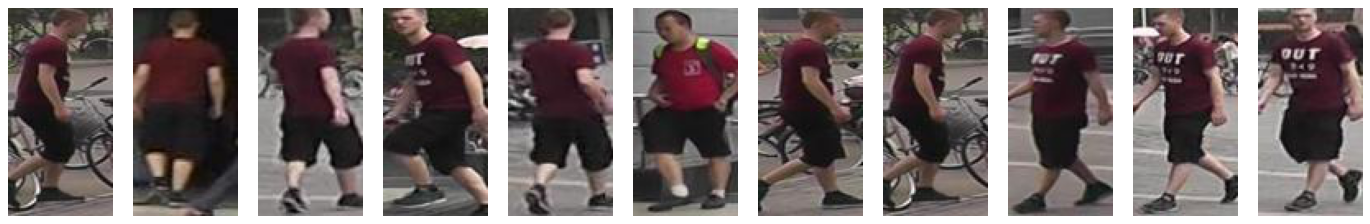

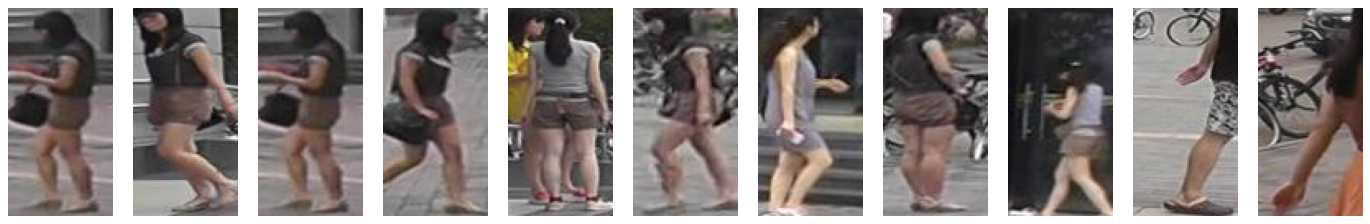

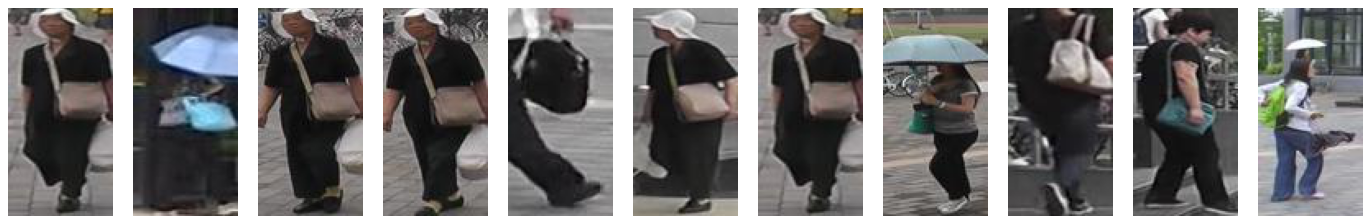

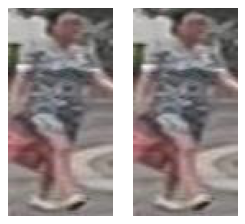

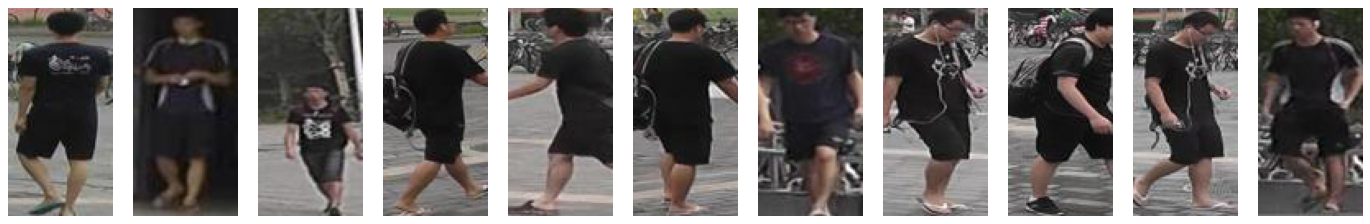

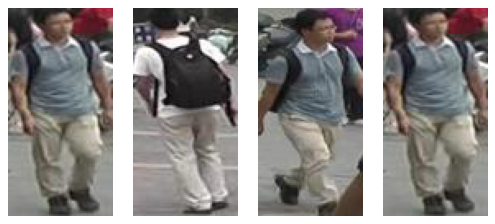

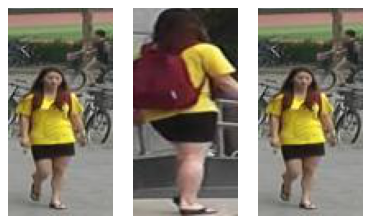

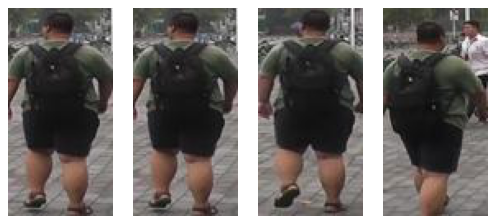

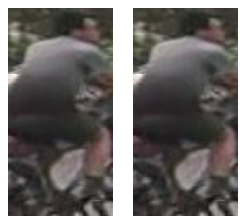

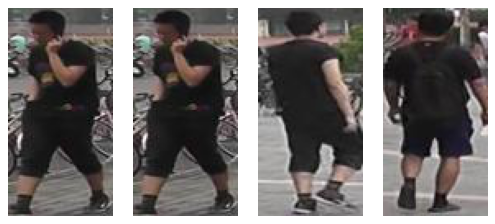

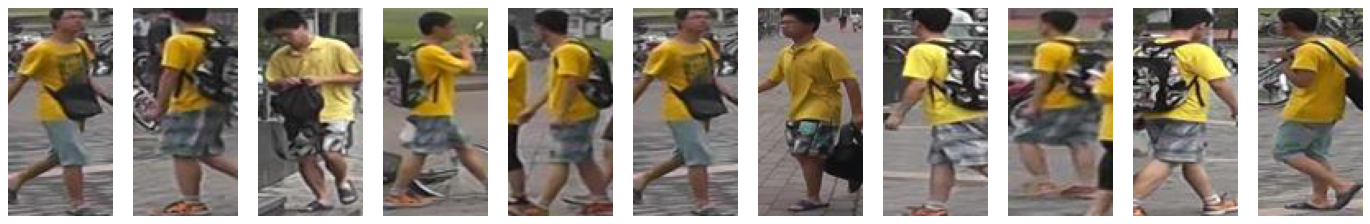

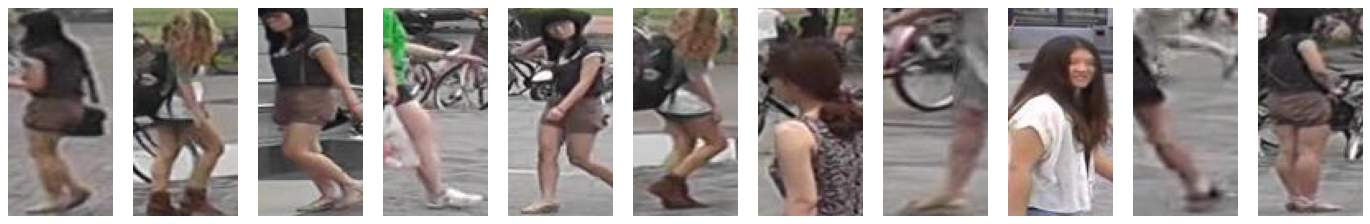

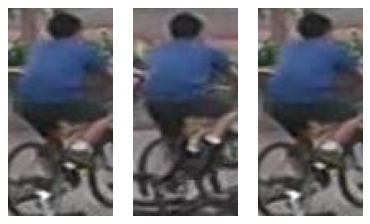

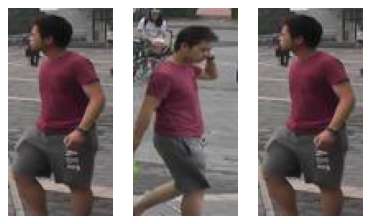

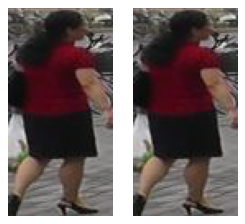

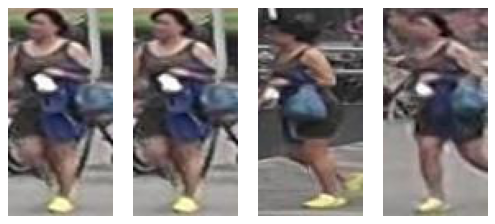

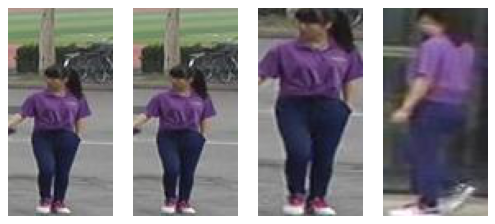

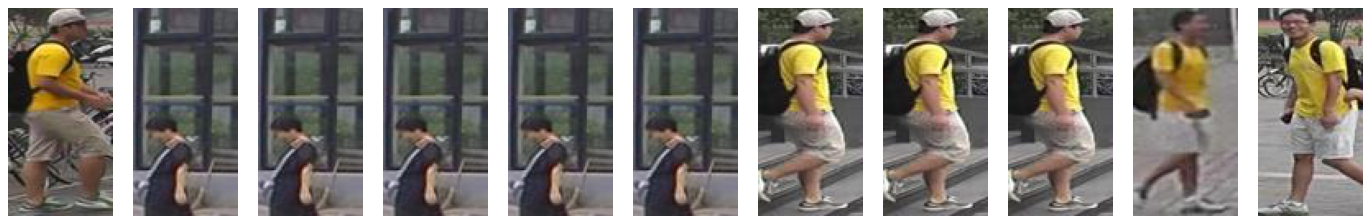

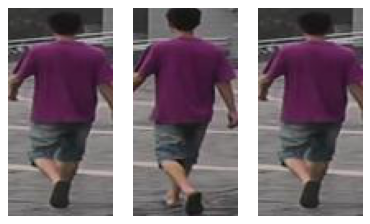

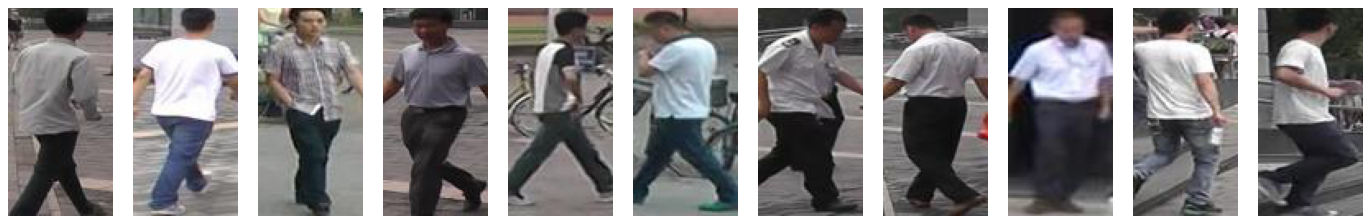

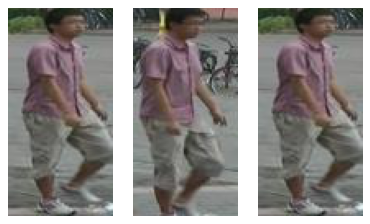

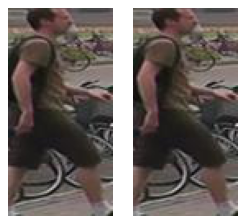

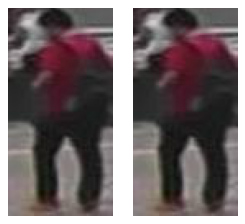

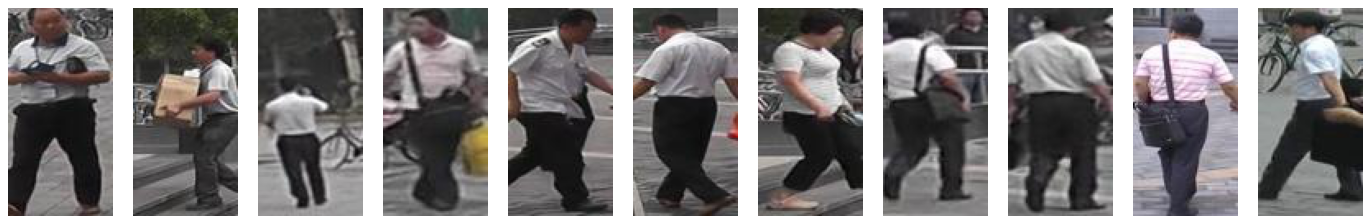

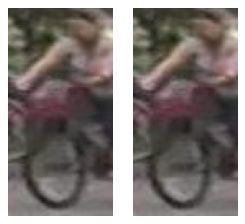

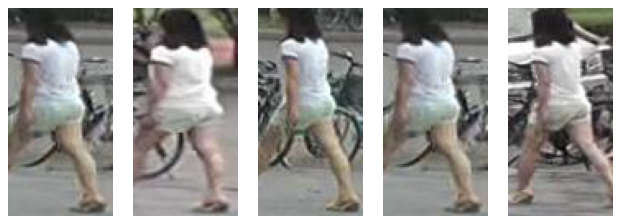

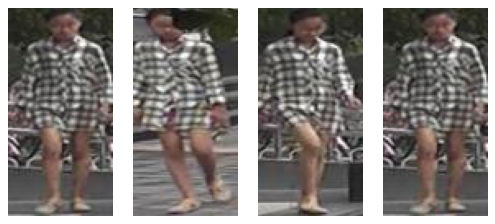

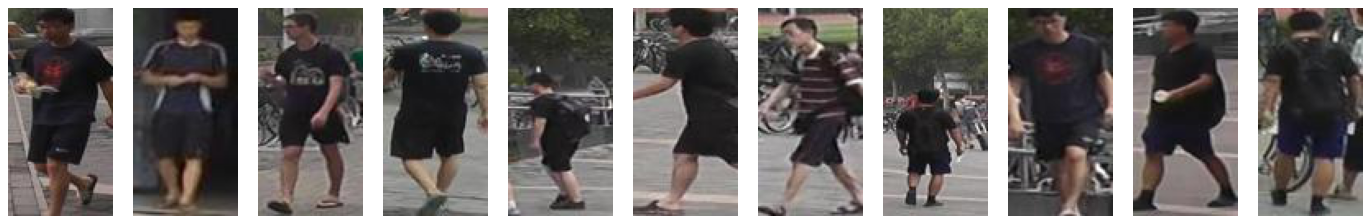

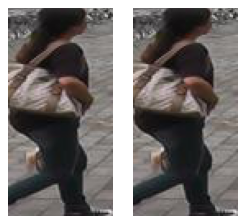

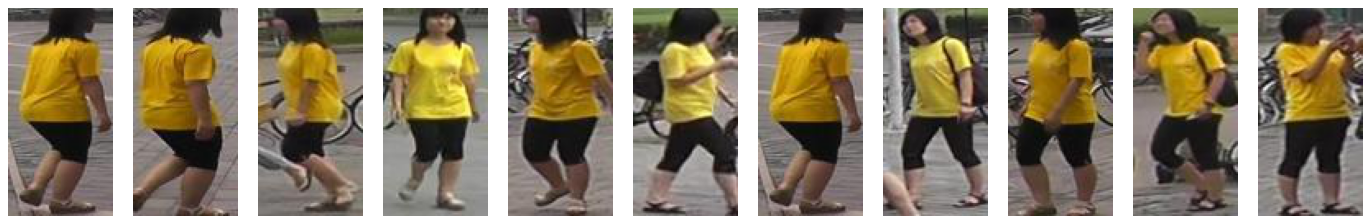

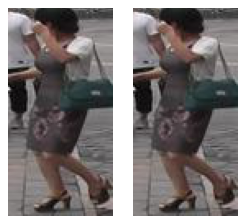

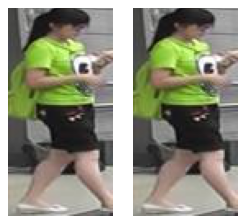

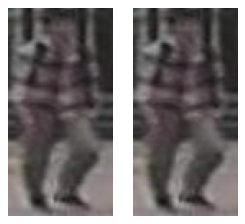

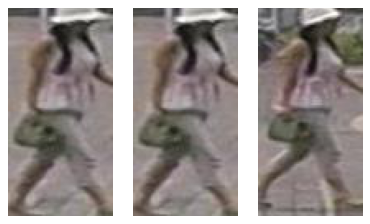

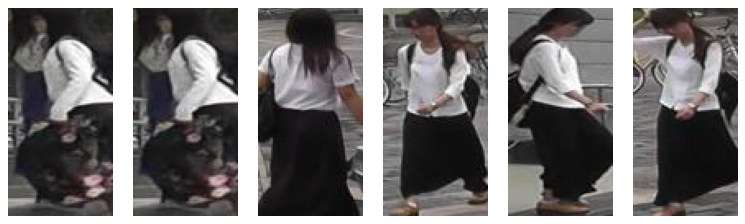

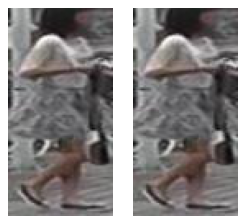

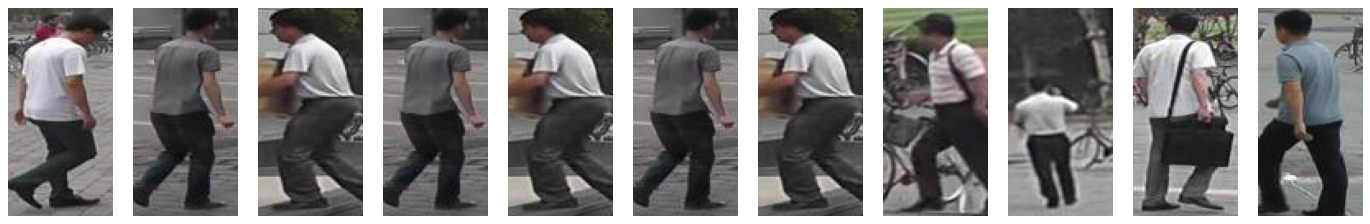

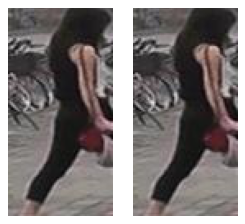

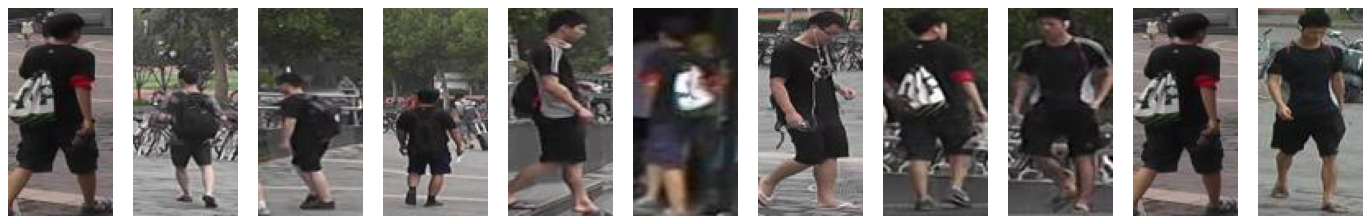

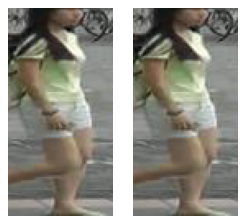

In [ ]:
print("RESULTS 40 queries")

i = 40
for k in query_results:
  imgs = [f'./project_dataset/queries/{k}'] + [f'./project_dataset/test/{f}' for f in query_results[k] [:10] ]
  show_img(imgs)
  i -= 1
  if i==0: break

In [ ]:
# write results

# post processing
for k in query_results:
  query_results[k] = query_results[k][:75]

# save file
with open('reid_test.txt', mode='w') as reid_file:
  for q, found in query_results.items():
    row  =  f'{q}: {", ".join(found)}\n'
    reid_file.write(row)